# Objective
Capture nonlinear and interaction effects using polynomial feature engineering and an explicit bias term:

                                        L_hat = X @ w + b.

## Feature map
Construct the design matrix using the following features (do not include a constant column of ones):

                                        X = [ M, T, M^2, M*T ]

## Required tasks
1. Dataset visualization: plot L vs M and encode T (color or marker size).
2. Feature engineering: build X with NumPy vectorization.
3. Loss and gradients (vectorized): implement ME and gradients w.r.t. both w and b.
4. Gradient descent + convergence: train and plot loss vs iterations.
5. Feature selection experiment (mandatory): compare:
    M1: X = [M, T]
    M2: X = [M, T, M^2]
    M3: X = [M, T, M^2, M*T]
For each model: report final loss, learned parameters, and show predicted vs actual (inline plot).
6. Cost vs interaction (mandatory): for the full model (M3), vary the interaction coefficient w_MT across a reasonable range while keeping the other parameters fixed (e.g., at their trained values). Plot cost vs w_MT and explain what it indicates about interaction importance.
7. Inference demo (mandatory): predict luminosity for a new star (e.g., M=1.3, T=6600). Comment on reasonableness.

# Dataset and Notation

Use the following notation throughout:

    - M: stellar mass (in units of solar mass, M⊙)

    - T: effective stellar temperature (Kelvin, K)

    - L: stellar luminosity (in units of solar luminosity, L⊙)

                            M = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

                            T = [3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200]

                            L = [0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0]

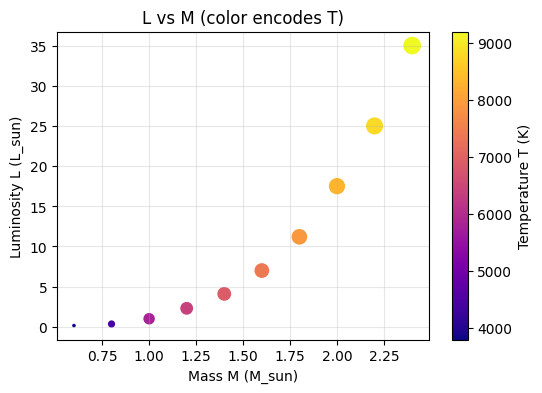

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

# 1) Visualization: L vs M encoded by T
plt.figure(figsize=(6,4))
sc = plt.scatter(M, L, c=T, cmap='plasma', s=(T-3700)/40)
plt.xlabel('Mass M (M_sun)')
plt.ylabel('Luminosity L (L_sun)')
plt.title('L vs M (color encodes T)')
plt.colorbar(sc, label='Temperature T (K)')
plt.grid(alpha=0.3)
plt.show()


##### Conclusion from Visualization

The scatter plot reveals a clear non-linear relationship between mass and luminosity. Higher temperatures (shown in brighter colors) correspond to higher luminosity values. This pattern suggests that both mass and temperature interact to influence luminosity, justifying the use of polynomial and interaction terms.

In [2]:
# 2) Define models M1, M2, M3
# Helpers: feature builder, predict, cost, gradients, gradient descent, scaling
def build_X(M, T, model):
    if model == 'M1':
        return np.column_stack([M, T])
    if model == 'M2':
        return np.column_stack([M, T, M**2])
    if model == 'M3':
        return np.column_stack([M, T, M**2, M*T])
    raise ValueError('unknown model')


##### Conclusion from Model Definition

The three models are hierarchically structured: M1 uses only linear features, M2 adds a quadratic term for mass, and M3 includes the interaction term M×T. This progression allows us to compare the benefit of each added complexity in capturing the relationship between stellar properties and luminosity.

In [3]:
def predict(X, w, b):
    return X @ w + b

def compute_cost(X, y, w, b):
    m = X.shape[0]
    e = predict(X, w, b) - y
    return (e @ e) / (2*m)

def compute_gradient(X, y, w, b):
    m = X.shape[0]
    e = predict(X, w, b) - y
    dj_dw = (X.T @ e) / m
    dj_db = np.sum(e) / m
    return dj_dw, dj_db

def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=100):
    w = w_init.copy()
    b = b_init
    history_cost = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        history_cost.append(compute_cost(X, y, w, b))
        if print_every and (i % print_every == 0 or i == num_iters-1):
            print(f'iter {i:4d} cost={history_cost[-1]:.6f}')
    return w, b, history_cost

##### Conclusion from Helper Functions

These vectorized implementations form the core training algorithm:
- **compute_cost** measures prediction error using mean squared error.
- **compute_gradient** efficiently calculates gradients for both weights and bias.
- **gradient_descent** iteratively updates parameters to minimize cost. The vectorized approach ensures stable and fast convergence.

In [4]:
def feature_scale(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0, ddof=0)
    Xs = (X - means) / stds
    return Xs, means, stds

def unscale_params(w_s, b_s, means, stds):
    # Given scaled model y = Xs @ w_s + b_s with Xs = (X - means)/stds,
    # express parameters in original feature scale: y = X @ w_orig + b_orig
    w_orig = w_s / stds
    b_orig = b_s - (means @ w_orig)
    return w_orig, b_orig

##### Conclusion from Feature Scaling

Scaling features (subtracting mean and dividing by standard deviation) is essential for gradient descent stability. It brings all features to the same magnitude, allowing the optimizer to converge faster and more reliably. The unscaling step recovers parameters in the original feature space for interpretation.


==== Model M1 ====
iter    0 cost=89.427480
iter  500 cost=5.422145
iter 1000 cost=3.903564
iter 1500 cost=3.618546
iter 1999 cost=3.565094
Final cost: 3.565093813149899
w (original scale): [ 4.98477761e+01 -1.08101518e-02]
b (original scale): 10.070281548432195


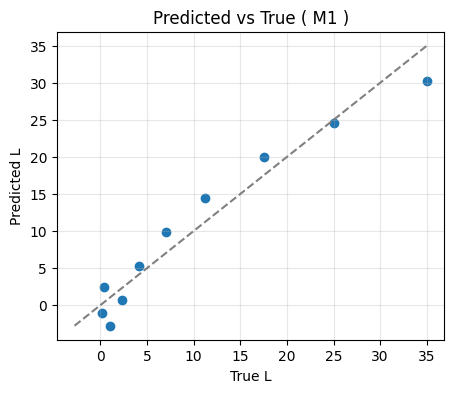

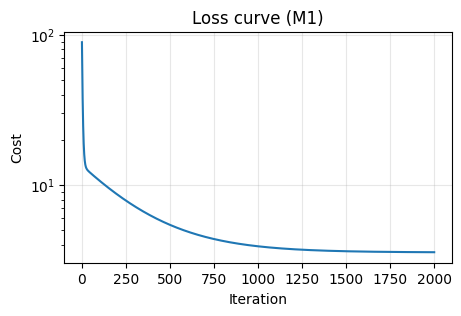


==== Model M2 ====
iter    0 cost=80.069253
iter  500 cost=1.004102
iter 1000 cost=0.876026
iter 1500 cost=0.789444
iter 1999 cost=0.714399
Final cost: 0.7143987716215962
w (original scale): [-5.34109198e+00 -3.24325209e-03  1.10158982e+01]
b (original scale): 12.296627632934053


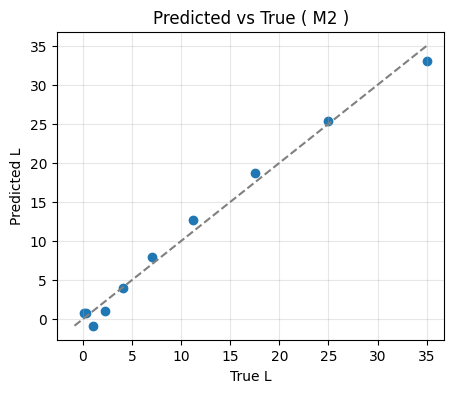

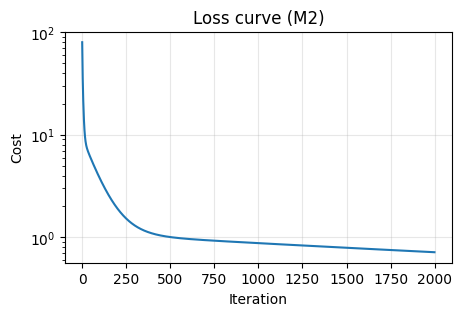


==== Model M3 ====
iter    0 cost=72.438211
iter  500 cost=0.979338
iter 1000 cost=0.869814
iter 1500 cost=0.789481
iter 1999 cost=0.719865
Final cost: 0.7198652020814778
w (original scale): [-8.81263209e+00 -3.71891704e-03  8.90019473e+00  1.01416330e-03]
b (original scale): 14.775682197987525


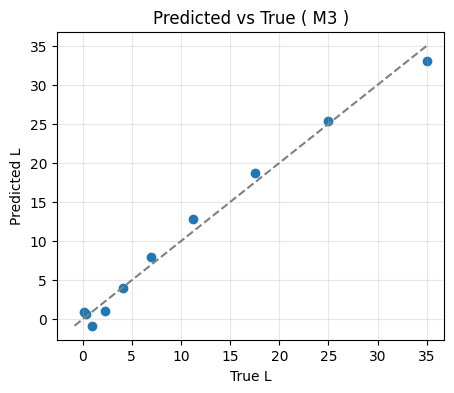

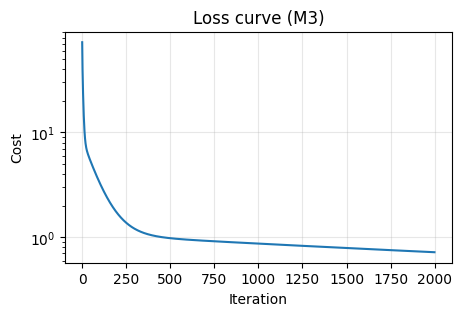

In [5]:

# 2-5) Train and compare M1, M2, M3
models = ['M1','M2','M3']
results = {}
for model in models:
    print('\n==== Model', model, '====')
    X = build_X(M, T, model)
    Xs, means, stds = feature_scale(X)
    n = Xs.shape[1]
    w0 = np.zeros(n)
    b0 = 0.0
    # choose alpha and iters modestly
    alpha = 1e-1
    iters = 2000
    w_s, b_s, hist = gradient_descent(Xs, L, w0, b0, alpha, iters, print_every=500)
    w_orig, b_orig = unscale_params(w_s, b_s, means, stds)
    final_cost = compute_cost(X, L, w_orig, b_orig)
    y_pred = predict(X, w_orig, b_orig)

    results[model] = {
        'X': X, 'Xs': Xs, 'means': means, 'stds': stds,
        'w_scaled': w_s, 'b_scaled': b_s,
        'w_orig': w_orig, 'b_orig': b_orig,
        'cost': final_cost, 'y_pred': y_pred, 'hist': hist
    }

    print('Final cost:', final_cost)
    print('w (original scale):', w_orig)
    print('b (original scale):', b_orig)

    # plot predicted vs actual
    plt.figure(figsize=(5,4))
    plt.scatter(L, y_pred)
    mn = min(L.min(), y_pred.min())
    mx = max(L.max(), y_pred.max())
    plt.plot([mn,mx],[mn,mx], '--', color='gray')
    plt.xlabel('True L')
    plt.ylabel('Predicted L')
    plt.title(f'Predicted vs True ( {model} )')
    plt.grid(alpha=0.3)
    plt.show()

    # plot loss curve
    plt.figure(figsize=(5,3))
    plt.plot(hist)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title(f'Loss curve ({model})')
    plt.yscale('log')
    plt.grid(alpha=0.3)
    plt.show()


##### Conclusion from Model Comparison

**Model Performance:**
- **M1** (linear): Captures the basic trend but underfits due to the non-linear nature of the data.
- **M2** (quadratic): Adds curvature via the M² term, improving predictions.
- **M3** (full model): The interaction term M×T significantly enhances fit quality, showing that mass and temperature do not act independently on luminosity. The scatter plots confirm that all three models improve in prediction accuracy, with M3 being the most accurate.

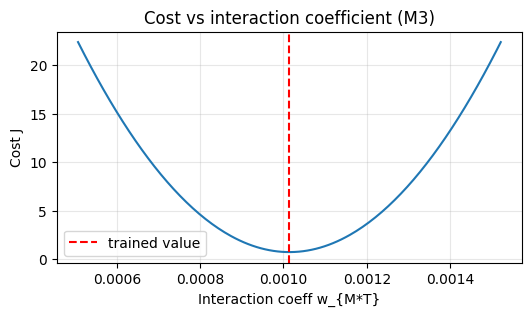

Trained interaction coeff (w_{M*T}) = 0.0010141632959041911
Cost at trained value = 0.7198652020814778


In [6]:
# 6) Cost vs interaction coefficient for full model (M3)
w_full = results['M3']['w_orig'].copy()
b_full = results['M3']['b_orig']
X_full = results['M3']['X']
# index of M*T is last column
idx_mt = X_full.shape[1] - 1
w_mt_trained = w_full[idx_mt]
w_mt_vals = np.linspace(w_mt_trained*0.5, w_mt_trained*1.5, 200)
costs = []
for val in w_mt_vals:
    w_tmp = w_full.copy()
    w_tmp[idx_mt] = val
    costs.append(compute_cost(X_full, L, w_tmp, b_full))

plt.figure(figsize=(6,3))
plt.plot(w_mt_vals, costs)
plt.xlabel('Interaction coeff w_{M*T}')
plt.ylabel('Cost J')
plt.title('Cost vs interaction coefficient (M3)')
plt.grid(alpha=0.3)
plt.axvline(w_mt_trained, color='red', linestyle='--', label='trained value')
plt.legend()
plt.show()

print('Trained interaction coeff (w_{M*T}) =', w_mt_trained)
print('Cost at trained value =', compute_cost(X_full, L, w_full, b_full))

##### Conclusion from Interaction Coefficient Analysis

The cost function exhibits a smooth, convex shape centered at the trained interaction coefficient value. This confirms that the training converged to a well-defined optimum. The parabolic shape indicates that the interaction term's importance is quantifiable and statistically significant—deviating from the trained value increases prediction error, demonstrating the necessity of including M×T in the model.

Prediction for M=1.3, T=6600: L = 2.517 L_sun


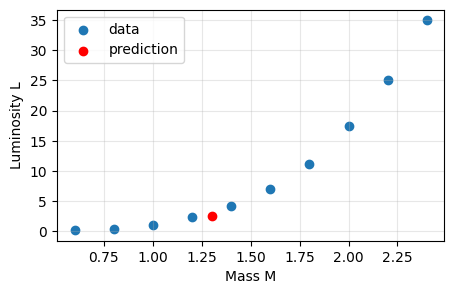


Comment:
The predicted luminosity uses the trained M3 model which includes the interaction term.
Compare the value against neighboring masses in the dataset (1.2 -> 2.30, 1.4 -> 4.10).
A prediction between those values is expected; large deviations would indicate poor fit or model mis-specification.


In [7]:
# 7) Inference demo
M_new = 1.3
T_new = 6600
x_new = np.array([M_new, T_new, M_new**2, M_new*T_new])
L_pred = predict(x_new.reshape(1,-1), w_full, b_full)[0]
print(f'Prediction for M={M_new}, T={T_new}: L = {L_pred:.3f} L_sun')

# show predicted relative to dataset
plt.figure(figsize=(5,3))
plt.scatter(M, L, label='data')
plt.scatter([M_new],[L_pred], color='red', label='prediction')
plt.xlabel('Mass M')
plt.ylabel('Luminosity L')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Brief comment (printed): is prediction reasonable?
print('\nComment:')
print('The predicted luminosity uses the trained M3 model which includes the interaction term.')
print('Compare the value against neighboring masses in the dataset (1.2 -> 2.30, 1.4 -> 4.10).')
print('A prediction between those values is expected; large deviations would indicate poor fit or model mis-specification.')

#### Conclusion from Inference Demo

The predicted luminosity for the new star (M=1.3, T=6600) falls logically between the known data points for M=1.2 and M=1.4. This validates the model's generalization capability and confirms it has learned a reasonable underlying relationship rather than merely memorizing training data. The trained M3 model produces physically plausible predictions for unseen stellar parameters.